In [1]:
import awkward as ak
import numpy as np
import pickle
import hist
import coffea
from python.plugins import checkdir
%matplotlib inline

import matplotlib.pyplot as plt
import mplhep as hep
from mplhep.plot import soft_update_kwargs
plt.style.use([hep.style.CMS, hep.style.firamath])

In [2]:
#### Plot dijet systematics
fname = "coffeaOutput/dijet/dijetHists_ak4corr_JetHT_rap2.5_2017.pkl"
with open(fname, "rb") as f:
    result_data = pickle.load( f )
fname = "coffeaOutput/dijet/dijetHists_ak4ak8corr_QCDsim_rap2.5_MG_nominal_2017.pkl"
with open(fname, "rb") as f:
    result_mc = pickle.load( f )
# fname = "coffeaOutput/trijet/trijetHists_JetHT_pt200.0_rapidity2.5_nominal2018.pkl"
# with open(fname, "rb") as f:
#     result_data = pickle.load( f )
# fname = "coffeaOutput/trijet/trijetHists_wXSscaling_QCDsim_pt200.0rapidity2.5_allUnc2018.pkl"
# with open(fname, "rb") as f:
#     result_mc = pickle.load( f )
year = fname[-8:-4]
# fname = "coffeaOutput/trijetHists_JetHT_pt200-Copy1.0_rappidity2.5_NoneHEMveto2018.pkl"
# with open(fname, "rb") as f:
#     result_mc_older = pickle.load( f )
if "trijet" in fname:
    os_path = 'plots/syst/trijet/'
else: os_path = 'plots/syst/dijet/'
# print(result_mc['cutflow'])
os_path=os_path+"test"
checkdir(os_path)

In [3]:
#### Check available uncertainties

In [4]:
def getTotSyst(result, histname, axis='mreco'):
    hist = result[histname]
    availSysts = [ax for ax in result[histname].project("syst").axes[0]]
#     syst_uncorr = [
#     'jerUp','jerDown'
#     'PUSFUp','PUSFDown', #PDFs WIP
#     'L1prefiringDown', 'L1prefiringUp', 
#     'AbsoluteStatUp','AbsoluteStatDown',
#     'FlavorQCDUp','FlavorQCDDown',
#     'FragmentationUp','FragmentationDown',
#     'PileUpDataMCUp','PileUpDataMCDown',
#     'RelativeBalUp','RelativeBalDown',
#     'RelativeJEREC1Up','RelativeJEREC1Down',
#     'RelativeJEREC2Up','RelativeJEREC2Down',
#     'RelativePtEC1Up','RelativePtEC1Down',
#     'RelativePtEC2Up','RelativePtEC2Down',
#     'RelativeSampleUp','RelativeSampleDown',
#     'RelativeStatECUp','RelativeStatECDown',
#     'RelativeStatFSRUp','RelativeStatFSRDown',
#     'RelativeStatHFUp','RelativeStatHFDown',
# ]

#     absolute = ['AbsoluteMPFBiasUp', 'AbsoluteMPFBiasDown',
#                 'AbsoluteScaleUp', 'AbsoluteScaleDown']
#     pileuppt = ['PileUpPtBBUp', 'PileUpPtBBDown', 
#                 'PileUpPtEC1Up', 'PileUpPtEC1Down',
#                 'PileUpPtEC2Up', 'PileUpPtEC2Down', 
#                 'PileUpPtHFUp', 'PileUpPtHFDown', 
#                 'PileUpPtRefUp', 'PileUpPtRefDown']
#     relpt = ['RelativePtEC1Up', 'RelativePtEC1Down','RelativePtHFUp', 'RelativePtHFDown']
#     singlepion =     ['SinglePionECALUp', 'SinglePionECALDown','SinglePionHCALUp', 'SinglePionHCALDown']
#     timepteta = ['TimePtEtaUp', 'TimePtEtaDown']

    availSysts = [syst for syst in availSysts if syst!="nominal"]
    # syst_list = [syst for syst in availSysts if syst!="nominal" and syst not in syst_uncorr]
    # syst_uncorr = [syst for syst in syst_uncorr if syst in availSysts]
    # corr_grps = [absolute, pileuppt, relpt, singlepion, timepteta]
    sysErr = {}  
    for syst in availSysts:
        sysErr.update({syst: hist[{'syst':syst}].project(axis).values()})
    nom_values = hist[{'syst':'nominal'}].project(axis).values()
    sysErrTot_up = np.zeros_like(nom_values)
    sysErrTot_dn = np.zeros_like(nom_values)
    #### Loop through uncorrelated groups and make 
    # for grp in corr_grps:
    #     grp_unc_total_up  = np.zeros_like(nom_values)
    #     grp_unc_total_dn  = np.zeros_like(nom_values)
    #     for syst in grp:
    #         if syst in availSysts:
    #             syst_vals = sysErr[syst]
    #             if "Up" in syst:
    #                 deltasys = abs(syst_vals-nom_values)
    #                 grp_unc_total_up += deltasys
    #             if "Down" in syst:
    #                 deltasys = abs(nom_values-syst_vals)
    #                 grp_unc_total_dn += deltasys
    #     sysErrTot_up += grp_unc_total_up**2
    #     sysErrTot_dn += grp_unc_total_dn**2
    #### Loop through uncorrelated uncertainties and add together with correlated groups
    for syst, syst_vals in sysErr.items():
        if "Up" in syst:
            deltasys = syst_vals-nom_values
            sysErrTot_up = sysErrTot_up + deltasys**2
        if "Down" in syst:
            deltasys = nom_values-syst_vals
            sysErrTot_dn = sysErrTot_dn + deltasys**2
    sysErrTot_up = sysErrTot_up**0.5
    sysErrTot_dn = sysErrTot_dn**0.5
    return sysErrTot_up, sysErrTot_dn

In [5]:
#### Function for crosschecking adding of uncertainties in TUnfold --> Should be same
def getTotSystUnrolled(result, histname, axis='mgen'):
    hist = result[histname]
    availSysts = [ax for ax in result[histname].project("syst").axes[0]]
    pt_bins = [bin[0] for bin in result[histname].project('ptgen').axes[0]]
    syst_uncorr = [
    'jerUp','jerDown'
    'PUSFUp','PUSFDown', #PDFs WIP
    'L1prefiringDown', 'L1prefiringUp', 
    'AbsoluteStatUp','AbsoluteStatDown',
    'FlavorQCDUp','FlavorQCDDown',
    'FragmentationUp','FragmentationDown',
    'PileUpDataMCUp','PileUpDataMCDown',
    'RelativeBalUp','RelativeBalDown',
    'RelativeJEREC1Up','RelativeJEREC1Down',
    'RelativeJEREC2Up','RelativeJEREC2Down',
    'RelativePtEC1Up','RelativePtEC1Down',
    'RelativePtEC2Up','RelativePtEC2Down',
    'RelativeSampleUp','RelativeSampleDown',
    'RelativeStatECUp','RelativeStatECDown',
    'RelativeStatFSRUp','RelativeStatFSRDown',
    'RelativeStatHFUp','RelativeStatHFDown',
]

    absolute = ['AbsoluteMPFBiasUp', 'AbsoluteMPFBiasDown',
                'AbsoluteScaleUp', 'AbsoluteScaleDown']
    pileuppt = ['PileUpPtBBUp', 'PileUpPtBBDown', 
                'PileUpPtEC1Up', 'PileUpPtEC1Down',
                'PileUpPtEC2Up', 'PileUpPtEC2Down', 
                'PileUpPtHFUp', 'PileUpPtHFDown', 
                'PileUpPtRefUp', 'PileUpPtRefDown']
    relpt = ['RelativePtEC1Up', 'RelativePtEC1Down','RelativePtHFUp', 'RelativePtHFDown']
    singlepion =     ['SinglePionECALUp', 'SinglePionECALDown','SinglePionHCALUp', 'SinglePionHCALDown']
    timepteta = ['TimePtEtaUp', 'TimePtEtaDown']

    availSysts = [syst for syst in availSysts if availSysts]
    syst_list = [syst for syst in availSysts if syst!="nominal" and syst not in syst_uncorr]
    syst_uncorr = [syst for syst in syst_uncorr if syst in availSysts]
    corr_grps = [absolute, pileuppt, relpt, singlepion, timepteta]
    perBin_up = {}
    perBin_down = {}
    for i, bin in enumerate(pt_bins):
        sysErr = {}  
        for syst in availSysts:
            sysErr.update({syst: hist[{'ptgen':i,'syst':syst}].project(axis).values()})
        nom_values = hist[{'ptgen':i,'syst':'nominal'}].project(axis).values()
        sysErrTot_up = np.zeros_like(nom_values)
        sysErrTot_dn = np.zeros_like(nom_values)
        #### Loop through uncorrelated groups and make 
        for grp in corr_grps:
            grp_unc_total_up  = np.zeros_like(nom_values)
            grp_unc_total_dn  = np.zeros_like(nom_values)
            for syst in grp:
                if syst in availSysts:
                    syst_vals = sysErr[syst]
                    if "Up" in syst:
                        deltasys = abs(syst_vals-nom_values)
                        grp_unc_total_up += deltasys
                        print("Delta sys vals for syst ", syst, " ", deltasys)
                    if "Down" in syst:
                        deltasys = abs(nom_values-syst_vals)
                        grp_unc_total_dn += deltasys
                        print("Delta sys vals for syst ", syst, " ", deltasys)
            sysErrTot_up += grp_unc_total_up**2
            sysErrTot_dn += grp_unc_total_dn**2
        print("Correlated up unc. only for pt bin ", pt_bins[i], " ", sysErrTot_up)
        print("Correlated up unc. only for pt bin ", pt_bins[i], " ", sysErrTot_dn)
        #### Loop through uncorrelated uncertainties and add together with correlated groups
        for syst, syst_vals in sysErr.items():
            if "Up" in syst and syst in syst_uncorr:
                deltasys = syst_vals-nom_values
                sysErrTot_up = sysErrTot_up + deltasys**2
            if "Down" in syst and syst in syst_uncorr:
                deltasys = nom_values-syst_vals
                sysErrTot_dn = sysErrTot_dn + deltasys**2
        sysErrTot_up = sysErrTot_up**0.5
        sysErrTot_dn = sysErrTot_dn**0.5
        perBin_up[str(pt_bins[i])]=sysErrTot_up
        perBin_down[str(pt_bins[i])]=sysErrTot_dn
    return perBin_up, perBin_down

In [6]:
# perBin_up, perBin_down = getTotSystUnrolled(result_mc, 'response_matrix_u')
# print(perBin_up, perBin_down)

In [7]:
def plotDataMCwErrors(result_mc, result_data, hist_mc, hist_data, axVar, IOV, channel = "", norm = False, rax_lim=None, os_path=os_path):
    stat_unc_up = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
    stat_unc_down = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
    syst_unc_up, syst_unc_down = getTotSyst(result_mc, hist_mc, axis=axVar)
    print("Syst unc up vals: ", syst_unc_up)
    print("Syst unc down vals: ", syst_unc_down)
    #### following opts may be unnecessary
    tot_error_opts = {
            'label': 'Stat. + Syst. Unc.',
            'facecolor': 'orange',

            'linewidth': 0
        }
    stat_error_opts = {
            'label': 'Stat. Unc.',
                    'hatch': '///',
                    'edgecolor': 'black',
            'facecolor': 'none',
            'linewidth': 0
        }
    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }
    datahist = result_data[hist_data][{'syst':'nominal'}]
    mchist = result_mc[hist_mc][{'syst':'nominal'}]
    print("mchist", mchist)
    print("datahist", datahist)
    availAxes = [ax.name for ax in result_mc[hist_mc].axes]
    edges = [bin[0] for bin in result_mc[hist_mc].project(axVar).axes[0]] + [result_mc[hist_mc].project(axVar).axes[0][-1][1]]
    widths = result_mc[hist_mc].project(axVar).axes[0].widths
    print("widths", widths)
    xlim = edges[-1]
    fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(7,7),
                gridspec_kw={"height_ratios": (3, 1)},
                sharex=True)
    ax.yaxis.get_minor_locator().set_params(numticks=999, subs=(.2, .4, .6, .8))
    ax.set_ylabel(r'$\frac{Events}{Bin Size} (GeV^{-1})$', loc = 'top')
    if "pt" in axVar or "m"==axVar[0]: 
        ax.set_yscale('log')
    if "_g" in hist_mc and "m"==axVar[0]:
        ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
    else:
        ax.set_xlabel(r'$m_{RECO} (GeV)$' )
    ratio = np.ones_like(result_mc[hist_mc].project(axVar).values())
    #### Fill ratio plot
    rax.set_xlabel(None)
    if norm:
        mcvals = mchist.project(axVar)*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        datavals = datahist.project(axVar)
        stat_unc_up = stat_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        stat_unc_down = stat_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        syst_unc_up = syst_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        syst_unc_down = syst_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
    else:
        mcvals = mchist.project(axVar)
        datavals = datahist.project(axVar)
    print("mcvals", len(mcvals.values()))
    print(mcvals.values())
    print(datavals.values())
    print("datavals", len(datavals.values()))
    ratio = np.divide(mcvals.values(),datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    #### Add MC error bars
    print("Total unc up: ", mcvals.values()+stat_unc_up+syst_unc_up)

    ax.stairs(values=(mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5)/widths, edges = edges, baseline= (mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5)/widths,
                fill=True,
                **tot_error_opts,
            )
    ax.stairs(values=(mcvals.values()+stat_unc_up)/widths, edges = edges, baseline= (mcvals.values()-stat_unc_down)/widths,
                fill=True,
                **stat_error_opts,
            )
    hep.histplot(datavals, stack=False, histtype='errorbar',
                 ax=ax, marker =["."], color = 'Black', linewidth=1, binwnorm=True,
                 label=channel + " Data")
    hep.histplot(mcvals, stack=False, histtype='step',
                 ax=ax, linestyle ='-', color = 'Black', linewidth=1, binwnorm=True,
                 label=channel + " MC")
    ax.autoscale(axis='x', tight=True)
    #### Want to stack uncertainties
        # print("Values in bins: ", mchist.project(axVar).values(), " errors of bins ", mchist.project(axVar).variances())
    if rax_lim != None:
        rax.set_ylim(rax_lim[0], rax_lim[1])
    leg = ax.legend(loc='best', labelspacing=0.25)
    leg.set_visible(True)
    #### Get ratio err values and plot
    ratio_totterr_up = np.divide((mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5),datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_totterr_down = np.divide(mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_statterr_up = np.divide(mcvals.values()+stat_unc_up,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_statterr_down = np.divide(mcvals.values()-stat_unc_up,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    rax.stairs(values=ratio_totterr_up, edges = edges, baseline= ratio_totterr_down,
                fill=True,
                **tot_error_opts,
            )
    rax.stairs(values=ratio_statterr_up, edges = edges, baseline= ratio_statterr_down,
                fill=True,
                **stat_error_opts,
            )
    hep.histplot(ratio, edges, histtype='step', ax=rax, linestyle ="-", color = 'black', linewidth=1)
    hep.histplot(np.ones_like(ratio), edges, histtype='step',ax=rax,linestyle ="--", color = 'black', linewidth=1)
    
    rax.set_ylabel(r'$\frac{MC}{Data}$', loc = 'center')
    if ("eta" in axVar) | ("phi" in axVar):
        rax.set_xlim(-xlim, xlim)
    elif "pt" in axVar:
        rax.set_xlim(0, 2000)
        # rax.set_ylim(0.0,1.0)
    else:
        rax.set_xlim(0, xlim)
    hep.cms.label("Preliminary", data = True, loc=0, ax=ax, fontsize=18);
    plt.show()
    if norm:
        fig.savefig(os_path+"ULwErrs{}{}_{}_{}_normed.png".format(IOV,channel, hist_mc, axVar), bbox_inches="tight") 
    else:
        fig.savefig(os_path+"ULwErrs{}{}_{}_{}.png".format(IOV,channel, hist_mc, axVar), bbox_inches="tight") 

In [8]:
def plotDataMCwErrorsBinned(result_mc, result_data, hist_mc, hist_data, IOV, channel = "", axVar="mreco", norm = True, rax_lim=None, os_path=os_path, binwnorm=True):
    pt_edges = [bin[0] for bin in result_mc[hist_mc].project('ptreco').axes[0]] + [result_mc[hist_mc].project('ptreco').axes[0][-1][1]]
    for i in range(len(pt_edges)-1):
        stat_unc_up = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
        stat_unc_down = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
        syst_unc_up, syst_unc_down = getTotSyst(result_mc, hist_mc, axis=axVar)
        print("Syst unc up vals: ", syst_unc_up)
        print("Syst unc down vals: ", syst_unc_down)
        #### following opts may be unnecessary
        tot_error_opts = {
                'label': 'Stat. + Syst. Unc.',
                'facecolor': 'orange',
    
                'linewidth': 0
            }
        stat_error_opts = {
                'label': 'Stat. Unc.',
                        'hatch': '///',
                        'edgecolor': 'black',
                'facecolor': 'none',
                'linewidth': 0
            }
        data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'color': 'k',
                'elinewidth': 1,
            }
        datahist = result_data[hist_data][{'syst':'nominal', 'ptreco':i}]
        mchist = result_mc[hist_mc][{'syst':'nominal', 'ptreco':i}]
        availAxes = [ax.name for ax in result_mc[hist_mc].axes]
        edges = [bin[0] for bin in result_mc[hist_mc].project(axVar).axes[0]] + [result_mc[hist_mc].project(axVar).axes[0][-1][1]]
        widths = result_mc[hist_mc].project(axVar).axes[0].widths
        print("widths", widths)
        xlim = edges[-1]
        fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(7,7),
                    gridspec_kw={"height_ratios": (3, 1)},
                    sharex=True)
        ax.yaxis.get_minor_locator().set_params(numticks=999, subs=(.2, .4, .6, .8))
        ax.set_ylabel(r'$\frac{Events}{Bin Size} (GeV^{-1})$', loc = 'top')
        if not binwnorm:
            ax.set_ylabel(r'$Events$', loc = 'top')
        if "pt" in axVar or "m"==axVar[0]: 
            ax.set_yscale('log')
        if "_g" in hist_mc and "m"==axVar[0]:
            ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
        else:
            ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
        ratio = np.ones_like(result_mc[hist_mc].project(axVar).values())
        #### Fill ratio plot
        rax.set_xlabel(None)
        if norm:
            scale = datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
            mcvals = mchist.project(axVar)*scale
            datavals = datahist.project(axVar)
            stat_unc_up = stat_unc_up*scale
            stat_unc_down = stat_unc_down*scale
            syst_unc_up = syst_unc_up*scale
            syst_unc_down = syst_unc_down*scale
        else:
            mcvals = mchist.project(axVar)
            datavals = datahist.project(axVar)
        print("mcvals", len(mcvals.values()))
        print("datavals", len(datavals.values()))
        ratio = np.divide(mcvals.values(),datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        #### Add MC error bars
        print("Total unc up: ", mcvals.values()+stat_unc_up+syst_unc_up)
        ratio_up_tot = mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5
        ratio_dn_tot = mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5
        ratio_up_syst = mcvals.values()+stat_unc_up
        ratio_dn_syst = mcvals.values()-stat_unc_down
        print("Unc. ratio upper bound ", ratio_up_tot)
        if binwnorm:
            ratio_up_tot=ratio_up_tot/widths
            print("Unc. ratio upper bound ", ratio_up_tot , " after dividing by bin widths")
            ratio_dn_tot=ratio_dn_tot/widths
            ratio_up_syst=ratio_up_syst/widths
            ratio_dn_syst=ratio_dn_syst/widths
        ax.stairs(values=ratio_up_tot, edges = edges, baseline= ratio_dn_tot, fill=True,
                  **tot_error_opts,
                )
        ax.stairs(values=ratio_up_syst, edges = edges, baseline= ratio_dn_syst, fill=True,
                    **stat_error_opts,
                )
        print("Data vals ", datavals.values(), " and MC vals ", mcvals.values())
        hep.histplot(datavals, stack=False, histtype='errorbar', binwnorm=binwnorm, 
                     ax=ax, marker =["."], color = 'Black', linewidth=1, 
                     label=channel + " Data")
        hep.histplot(mcvals, stack=False, histtype='step',
                     ax=ax, linestyle ='-', color = 'Black', linewidth=1, binwnorm = binwnorm,
                     label=channel + " MC "+" pt "+str(pt_edges[i])+"-"+str(pt_edges[i+1]))
        ax.autoscale(axis='x', tight=True)
        #### Want to stack uncertainties
            # print("Values in bins: ", mchist.project(axVar).values(), " errors of bins ", mchist.project(axVar).variances())
        if rax_lim != None:
            rax.set_ylim(rax_lim[0], rax_lim[1])
        leg = ax.legend(loc='best', labelspacing=0.25)
        leg.set_visible(True)
        #### Get ratio err values and plot
        ratio_totterr_up = np.divide((mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5),datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_totterr_down = np.divide(mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_statterr_up = np.divide(mcvals.values()+stat_unc_up,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_statterr_down = np.divide(mcvals.values()-stat_unc_up,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)

        rax.stairs(values=ratio_totterr_up, edges = edges, baseline= ratio_totterr_down,
                    fill=True,
                    **tot_error_opts,
                )
        rax.stairs(values=ratio_statterr_up, edges = edges, baseline= ratio_statterr_down,
                    fill=True,
                    **stat_error_opts,
                )
        hep.histplot(ratio, edges, histtype='step', ax=rax, linestyle ="-", color = 'black', linewidth=1)
        hep.histplot(np.ones_like(ratio), edges, histtype='step',ax=rax,linestyle ="--", color = 'black', linewidth=1)
        
        rax.set_ylabel(r'$\frac{MC}{Data}$', loc = 'center')
        if ("eta" in axVar) | ("phi" in axVar):
            rax.set_xlim(-xlim, xlim)
        elif "pt" in axVar:
            rax.set_xlim(0, 2000)
            # rax.set_ylim(0.0,1.0)
        else:
            rax.set_xlim(0, xlim)
        hep.cms.label("Preliminary", data = True, loc=0, ax=ax, fontsize=18);
        plt.show()
        if norm:
            fig.savefig(os_path+"ULwErrs{}{}_{}_{}_pt{}_{}normed.png".format(IOV,channel, hist_mc, axVar, pt_edges[i], pt_edges[i+1]), bbox_inches="tight") 
        else:
            fig.savefig(os_path+"ULwErrs{}{}_{}_{}_pt{}_{}.png".format(IOV,channel, hist_mc, axVar, pt_edges[i], pt_edges[i+1]), bbox_inches="tight") 

Syst unc up vals:  [4.41398427e+05 6.56087323e+06 4.33490241e+07 1.22073427e+08
 3.75748761e+08 2.12774582e+08 1.96714691e+08 1.78168413e+08
 1.46949272e+08 1.16456616e+08 9.71455618e+07 7.85193200e+07
 1.12720896e+08 3.72241074e+07 1.14645735e+07 3.56021944e+06
 1.53815023e+06 2.42756721e+05 8.41006817e+04 1.85230156e+01]
Syst unc down vals:  [3.91977208e+05 5.90860996e+06 3.90774939e+07 1.09613587e+08
 3.33290931e+08 1.75300780e+08 1.60229588e+08 1.46780023e+08
 1.21968155e+08 9.73127430e+07 8.23319044e+07 6.71442787e+07
 9.65549726e+07 3.17122233e+07 9.70502199e+06 2.99226662e+06
 1.27782842e+06 2.02161240e+05 7.01726914e+04 1.52222689e+01]
mchist Hist(
  IntCategory([-1], growth=True, name='jk', label='Jackknife section'),
  Variable([200, 260, 350, 430, 540, 630, 690, 750, 810, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 800, 1300], name='mreco', label='m_{RECO} (GeV)'),
  storage=We

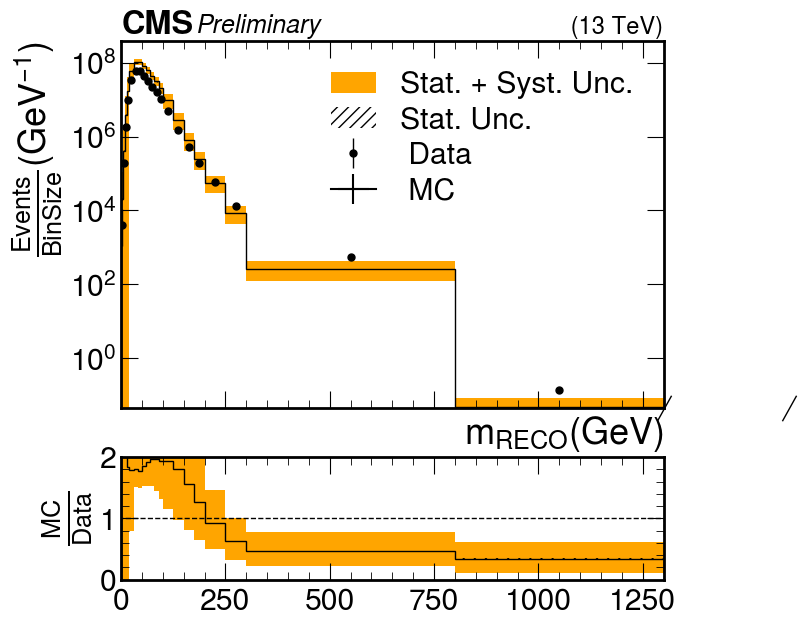

In [9]:
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2017, rax_lim=[0,2])

Syst unc up vals:  [4.41398427e+05 6.56087323e+06 4.33490241e+07 1.22073427e+08
 3.75748761e+08 2.12774582e+08 1.96714691e+08 1.78168413e+08
 1.46949272e+08 1.16456616e+08 9.71455618e+07 7.85193200e+07
 1.12720896e+08 3.72241074e+07 1.14645735e+07 3.56021944e+06
 1.53815023e+06 2.42756721e+05 8.41006817e+04 1.85230156e+01]
Syst unc down vals:  [3.91977208e+05 5.90860996e+06 3.90774939e+07 1.09613587e+08
 3.33290931e+08 1.75300780e+08 1.60229588e+08 1.46780023e+08
 1.21968155e+08 9.73127430e+07 8.23319044e+07 6.71442787e+07
 9.65549726e+07 3.17122233e+07 9.70502199e+06 2.99226662e+06
 1.27782842e+06 2.02161240e+05 7.01726914e+04 1.52222689e+01]
mchist Hist(
  IntCategory([-1], growth=True, name='jk', label='Jackknife section'),
  Variable([200, 260, 350, 430, 540, 630, 690, 750, 810, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 800, 1300], name='mreco', label='m_{RECO} (GeV)'),
  Variable([

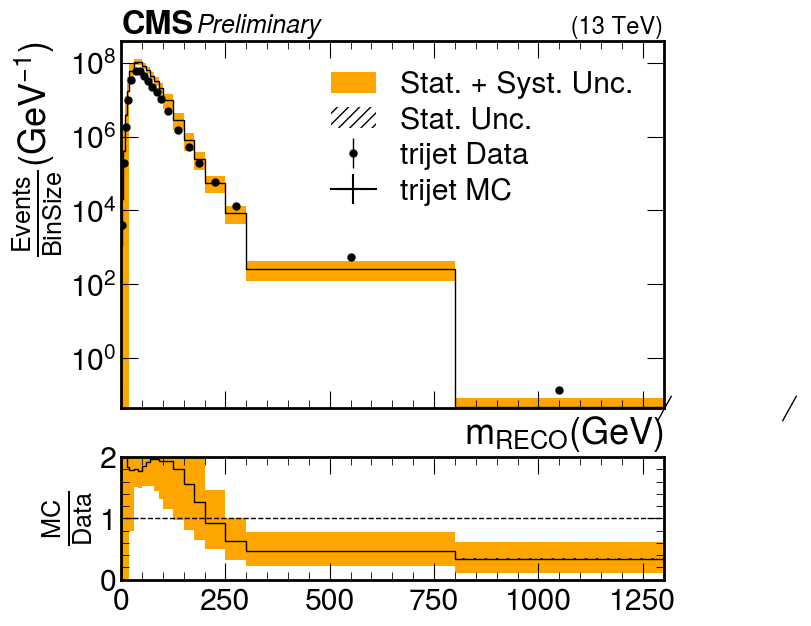

Syst unc up vals:  [4.41398427e+05 6.56087323e+06 4.33490241e+07 1.22073427e+08
 3.75748761e+08 2.12774582e+08 1.96714691e+08 1.78168413e+08
 1.46949272e+08 1.16456616e+08 9.71455618e+07 7.85193200e+07
 1.12720896e+08 3.72241074e+07 1.14645735e+07 3.56021944e+06
 1.53815023e+06 2.42756721e+05 8.41006817e+04 1.85230156e+01]
Syst unc down vals:  [3.91977208e+05 5.90860996e+06 3.90774939e+07 1.09613587e+08
 3.33290931e+08 1.75300780e+08 1.60229588e+08 1.46780023e+08
 1.21968155e+08 9.73127430e+07 8.23319044e+07 6.71442787e+07
 9.65549726e+07 3.17122233e+07 9.70502199e+06 2.99226662e+06
 1.27782842e+06 2.02161240e+05 7.01726914e+04 1.52222689e+01]
mchist Hist(
  IntCategory([-1], growth=True, name='jk', label='Jackknife section'),
  Variable([200, 260, 350, 430, 540, 630, 690, 750, 810, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 800, 1300], name='mreco', label='m_{RECO} (GeV)'),
  storage=We

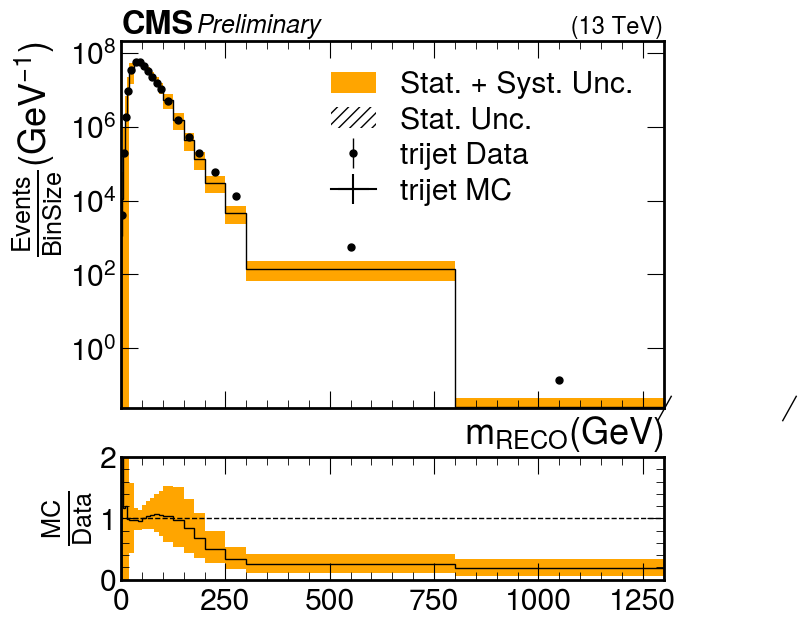

Syst unc up vals:  [2.41736155e+08 1.35988327e+08 6.92871016e+07 5.21228816e+07
 8.33860925e+07 6.84071136e+07 6.41212925e+07 6.12735995e+07
 5.75398699e+07 5.59341966e+07 5.64251875e+07 5.20775458e+07
 7.01799296e+07 1.83913535e+07 3.82864763e+06 6.42702708e+06
 1.55177142e+07 1.33058291e+07 2.99721368e+07 1.42261472e+06]
Syst unc down vals:  [2.00135133e+08 1.09715243e+08 5.52442911e+07 4.17033406e+07
 6.66347768e+07 5.47437859e+07 5.19983427e+07 4.93428449e+07
 4.58740060e+07 4.55427901e+07 4.78665204e+07 4.53725103e+07
 6.15508670e+07 1.58934019e+07 3.05882768e+06 5.80021677e+06
 1.40755853e+07 1.20732810e+07 2.71963294e+07 1.29076635e+06]
mchist Hist(
  IntCategory([-1], growth=True, name='jk', label='Jackknife section'),
  Variable([200, 260, 350, 430, 540, 630, 690, 750, 810, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 800, 1300], name='mreco', label='m_{RECO} (GeV)'),
  storage=We

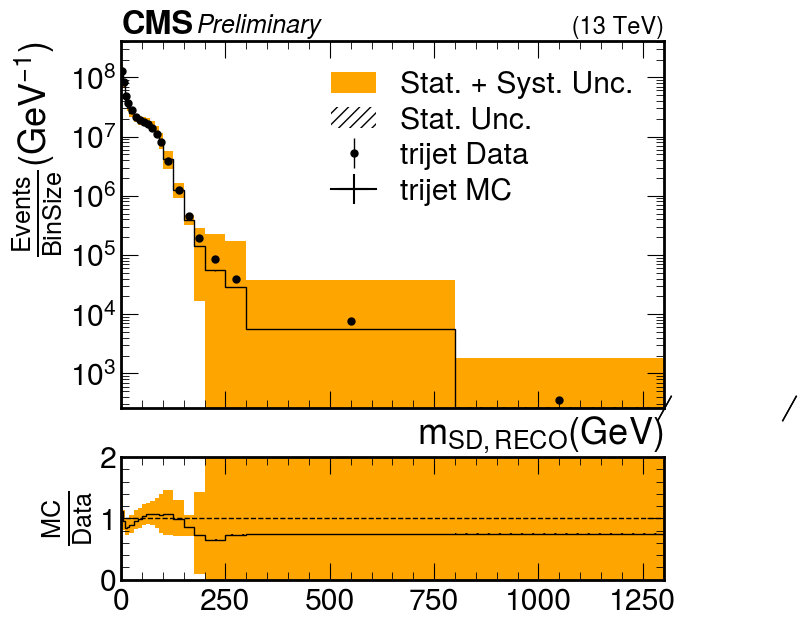

In [10]:
plotDataMCwErrors(result_mc, result_data, "response_matrix_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "trijet", rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "trijet", rax_lim=[0,2], norm=True)
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "trijet", rax_lim=[0.0,2], norm=True)

In [11]:
from python.plotting import plotSyst
#plotSyst(result_mc, "response_matrix_u", 'ptreco', label = r'2018 (13 TeV)', IOV='2018', channel='trijet', os_path=os_path)

In [12]:
# plotSyst(result_mc, "response_matrix_u", 'mreco', label = r'2018 (13 TeV)', IOV='2018', channel='trijet')

In [13]:
#### Plot dijet systematics
fname = "coffeaOutput/dijet/dijetHists_JetHT_pt200.0_rapidity2.5_2018.pkl"
fname = "coffeaOutput/dijet/dijetHists_JetHT_newMandPtBins_rapidity2.5_nominal2018.pkl"
with open(fname, "rb") as f:
    result_data = pickle.load( f )
#fname = "coffeaOutput/dijetHists_wXSscaling_QCDsim_pt200.0_rapidity2.5_allUncRespOnlyNEW2018.pkl"
# fname="coffeaOutput/dijet/dijetHists_wXSscaling_QCDsim_pt200.0_rapidity2.5_allUnc2018RespOnly.pkl"
fname = "coffeaOutput/dijet/dijetHists_wXSscaling_QCDsim_newMandPtBins_rapidity2.5_nominal2018.pkl"
with open(fname, "rb") as f:
    result_mc = pickle.load( f )

year = fname[-8:-4]
# fname = "coffeaOutput/trijetHists_JetHT_pt200-Copy1.0_rappidity2.5_NoneHEMveto2018.pkl"
# with open(fname, "rb") as f:
#     result_mc_older = pickle.load( f )
if "trijet" in fname:
    os_path = 'plots/syst/trijet/'
else: os_path = 'plots/syst/dijet/'
# print(result_mc['cutflow'])
checkdir(os_path)

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.08508401e+00 7.18251026e+04 1.57217294e+06
 4.39241627e+07 1.46982047e+08 1.80041771e+08 1.46301521e+08
 1.00340138e+08 6.35564968e+07 3.77502962e+07 1.96605809e+07
 1.08163701e+07 2.

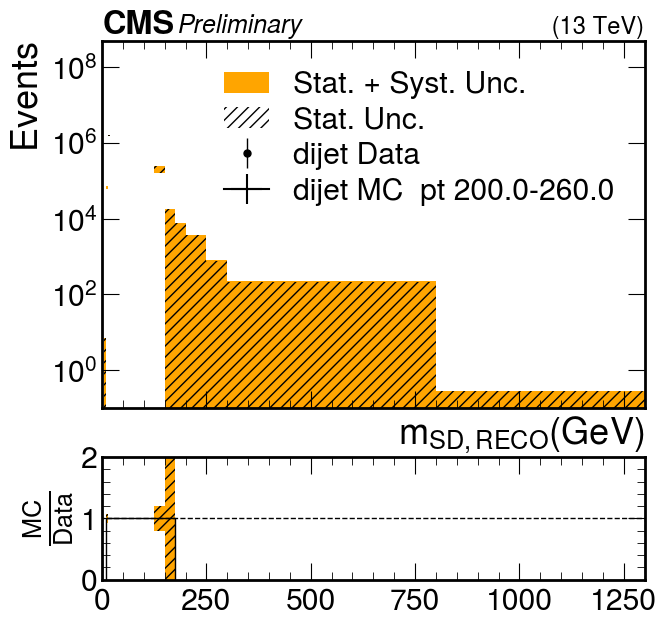

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.08508401e+00 1.84957804e+04 2.76895346e+05
 9.33206794e+06 4.43148638e+07 7.45753240e+07 7.48881168e+07
 6.14625067e+07 4.71529607e+07 3.45886881e+07 2.48375843e+07
 3.25304573e+07 7.

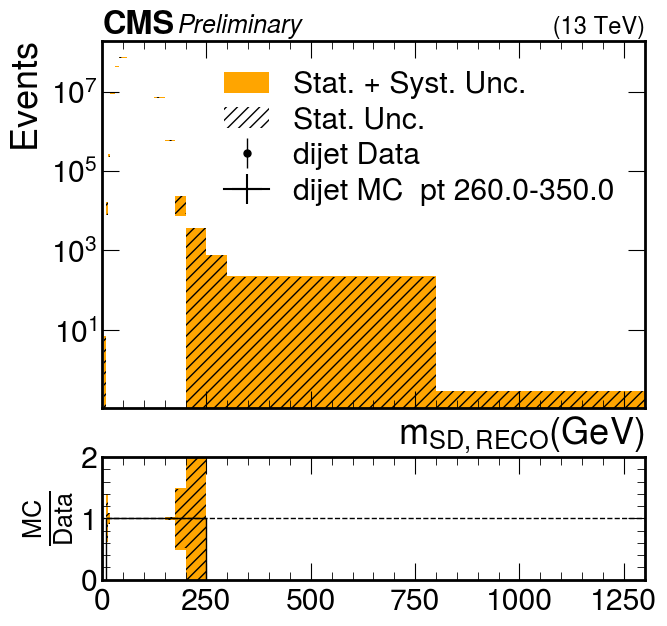

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 1.39693124e+01 6.92591807e+03 4.35314483e+04
 8.17143280e+05 4.51957205e+06 1.01809265e+07 1.29687646e+07
 1.22974025e+07 1.03234753e+07 8.40285013e+06 6.76663167e+06
 1.14461873e+07 6.

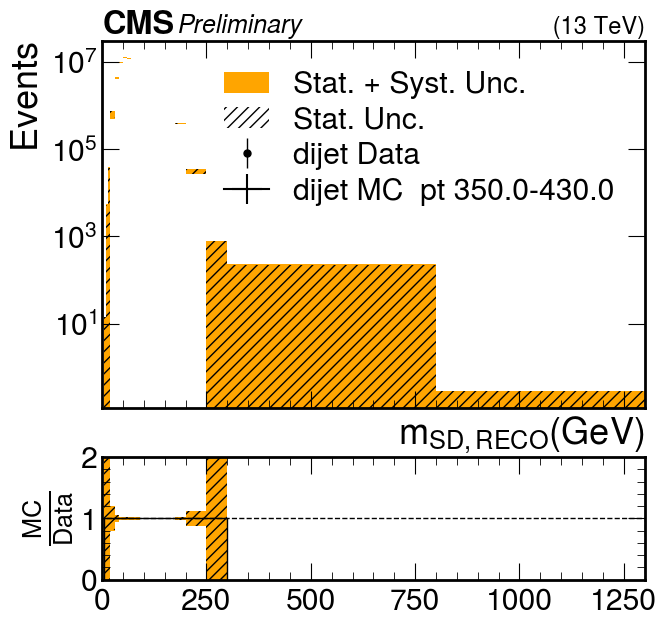

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.12209288e+00 6.26181963e+03 2.97399968e+04
 2.74600630e+05 1.06709097e+06 2.54285630e+06 3.93561672e+06
 4.27929581e+06 3.79506707e+06 3.24590234e+06 2.64760892e+06
 4.87219390e+06 3.

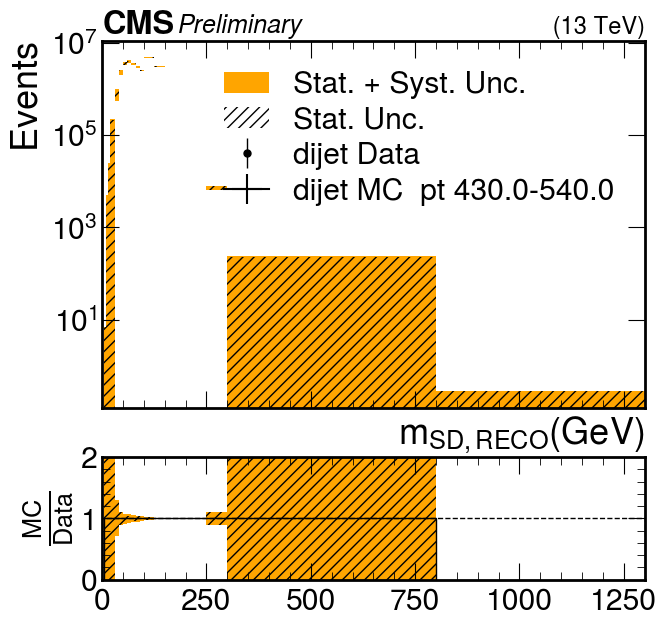

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 8.08971324e+00 6.17244768e+03 2.79433722e+04
 1.90237434e+05 3.81799861e+05 5.80976846e+05 9.60033655e+05
 1.14264249e+06 1.02493205e+06 9.05162617e+05 7.13188672e+05
 1.29706841e+06 8.

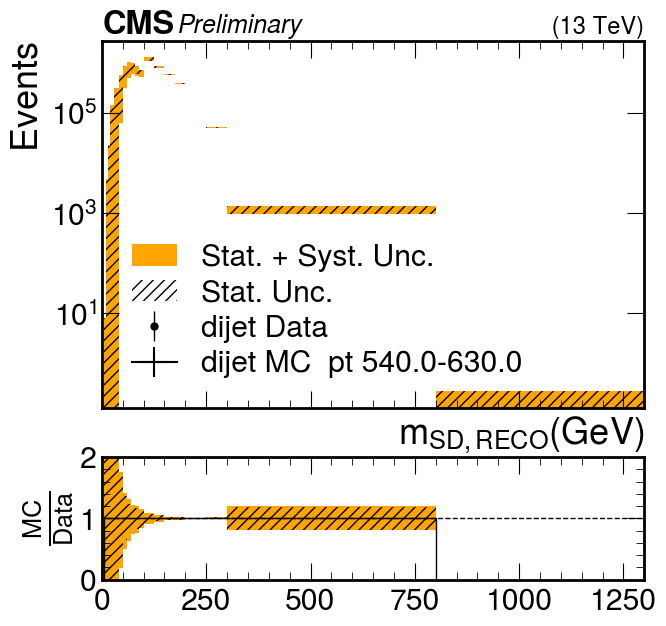

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.23292093e+00 6.15389568e+03 2.77540923e+04
 1.82525414e+05 3.10705918e+05 3.28141417e+05 4.89909145e+05
 5.58446985e+05 4.52420481e+05 4.04407044e+05 2.85188473e+05
 4.83138275e+05 2.

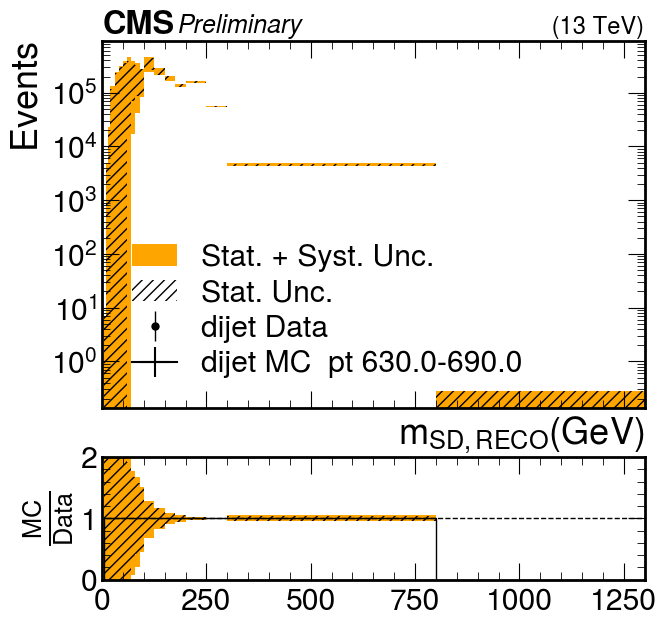

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.08508401e+00 6.15144053e+03 2.77215882e+04
 1.81574587e+05 3.01218313e+05 2.91099425e+05 4.14433595e+05
 4.58528760e+05 3.48880215e+05 3.11844451e+05 2.05956754e+05
 3.30681930e+05 1.

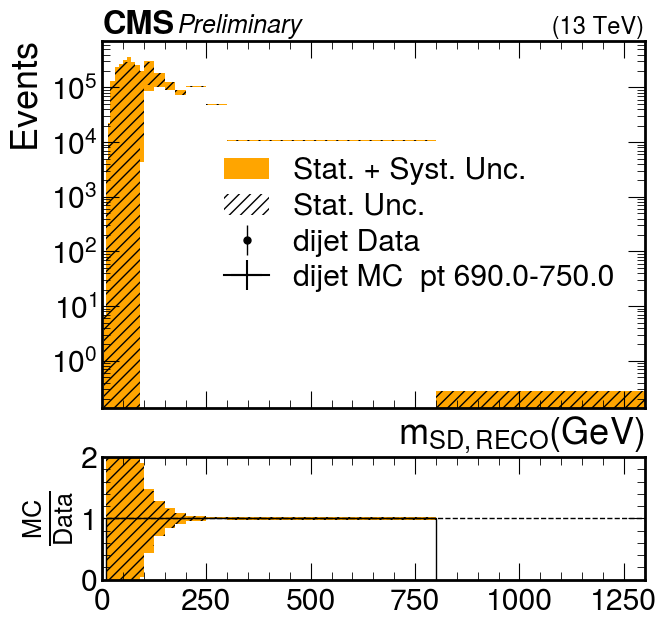

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.12907760e+00 6.14981028e+03 2.77116935e+04
 1.81139090e+05 2.97254135e+05 2.75531670e+05 3.80197752e+05
 4.09415511e+05 2.95530842e+05 2.62056254e+05 1.63179124e+05
 2.49281495e+05 1.

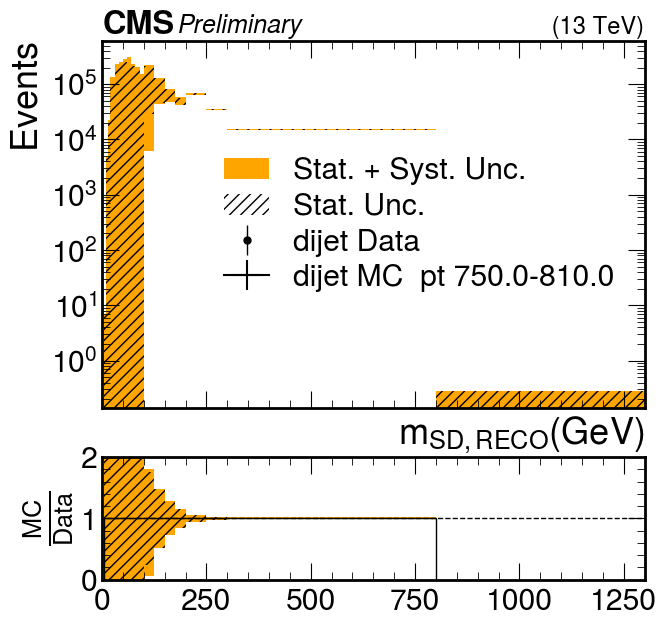

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
mcvals 20
datavals 20
Total unc up:  [0.00000000e+00 7.08874802e+00 6.15058506e+03 2.77113802e+04
 1.81122340e+05 2.97134134e+05 2.75580627e+05 3.82723621e+05
 4.17188954e+05 3.10667243e+05 2.83286114e+05 1.86848972e+05
 3.03026053e+05 1.

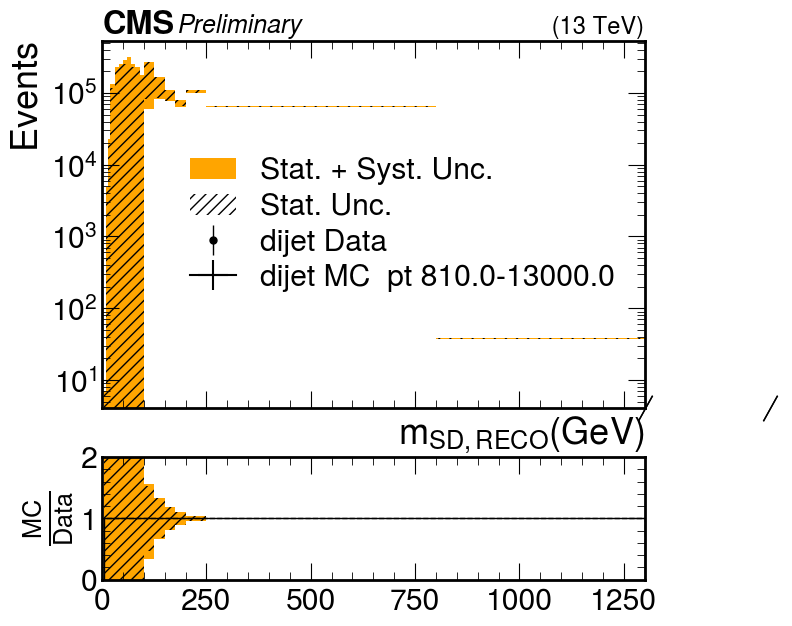

In [14]:
plotDataMCwErrorsBinned(result_mc, result_mc, "response_matrix_u", 'ptreco_mreco_u', "mreco", channel = "dijet", rax_lim=[0,2], binwnorm=False)

Syst unc up vals:  [0.00000000e+00 1.58803241e-01 1.57830654e+03 5.85972004e+03
 6.43834674e+04 8.03334641e+04 2.08487517e+04 1.26170388e+05
 1.69528425e+05 7.78179006e+04 7.41664674e+04 7.90006839e+03
 3.57519472e+04 2.93250819e+03 4.43311786e+03 1.73454765e+03
 1.78497288e+02 1.13014511e+02 8.01846749e+01 2.19788928e-02]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
mchist Hist(
  Variable([200, 260, 350, 430, 540, 630, 690, 750, 810, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 800, 1300], name='mreco', label='m_{RECO} (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.28644e+09, variance=2.32235e+11) (Wei

ValueError: operands could not be broadcast together with shapes (20,) (18,) (18,) 

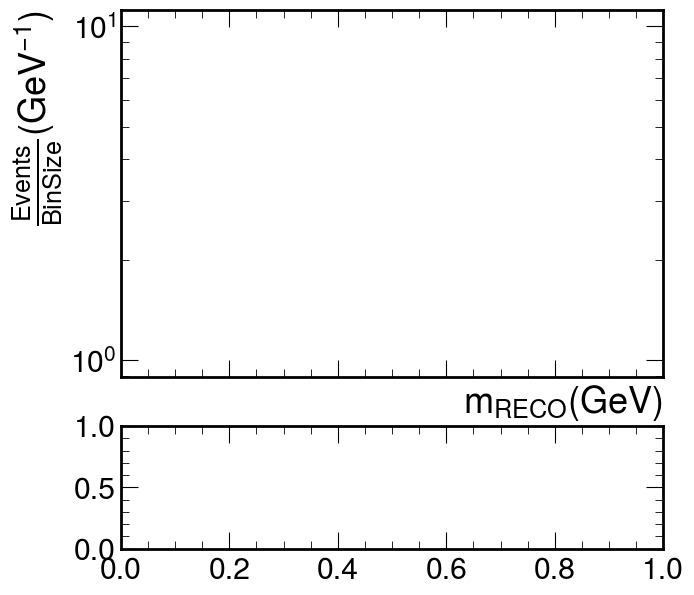

In [15]:

plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "dijet", rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "dijet")
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "ptreco", IOV=2018, channel = "dijet", norm=True)
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "dijet", norm=True, rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "dijet", norm=True, rax_lim=[0,2])


In [ ]:

#plotSyst(result_mc, "response_matrix_u", 'ptreco', label = r'2018 (13 TeV)', IOV='2018', channel='dijet')


In [ ]:

plotSyst(result_mc, "response_matrix_u", 'mreco', label = r'2018 (13 TeV)', IOV='2018', channel='dijet')


In [ ]:
#### Plot dijet systematics

histname="ptreco_mreco_u"
availAxes = [ax.name for ax in result_hem[histname].axes]
availSysts = [ax for ax in result_hem[histname].project("syst").axes[0]]
print([ax for ax in result_hem[histname].project("syst").axes[0]])
print("Available axes: ", availAxes)
print("Available systs ", availSysts)
def compareDatasets(result, histname, axVar, syst=None):
    if syst==None:
        syst = "nominal"
    edges = [bin[0] for bin in result[0][histname].project(axVar).axes[0]] + [result[0][histname].project(axVar).axes[0][-1][1]]
    fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(7,7),
                gridspec_kw={"height_ratios": (3, 1)},
                sharex=True)
    ratio = np.divide(result[0][histname][{'syst':syst}].project(axVar).values(),result[1][histname][{"syst":"nominal"}].project(axVar).values(),
                                    out=np.empty(np.array(result[1][histname][{"syst":syst}].project(axVar).values()).shape).fill(np.nan),
                                    where=result[1][histname][{"syst":syst}].project(axVar).values()!= 0,)
    hep.histplot(ratio, edges, stack=True, histtype='step', ax=rax, density=False, linestyle ="-", color = 'red', linewidth=1)
    hep.histplot(result[0][histname][{'syst':"nominal"}].project(axVar), stack=False, histtype='step', binwnorm=True, ax=ax, density=False, linestyle ='-', color = 'red', linewidth=1,label="hemVeto")
    hep.histplot(result[1][histname][{'syst':"nominal"}].project(axVar), stack=False, histtype='step', binwnorm=True, ax=ax, density=False, linestyle ='-', linewidth=1,label=syst)
    #### Fill ratio plot
    ax.set_xlabel(None)
    ax.autoscale(axis='x', tight=True)
    leg = ax.legend(loc='best', labelspacing=0.25)
    leg.set_visible(True)
    hep.histplot(np.ones_like(ratio), edges, stack=False, histtype='step',ax=rax, density=False, linestyle ="--", color = 'black', linewidth=1)
    rax.set_ylabel(r'$\frac{HEMveto}{Nominal}$', loc = 'center')
    rax.set_ylim(0.9,1.1)
compareDatasets([result_hem, result], 'ptreco_mreco_u', 'mreco')
compareDatasets([result_hem, result], 'ptreco_mreco_u', 'ptreco')

In [ ]:
data = [result[histname][{'syst':"nominal"}].project('mreco'), 
                  result[histname][{'syst':"nominal"}].project('mreco'),
         result[histname][{'syst':"nominal"}].project('ptreco'), 
                  result[histname][{'syst':"nominal"}].project('ptreco')]
hemdata = [result_hem[histname][{'syst':"nominal"}].project('mreco'), 
              result_hem[histname][{'syst':"nominal"}].project('mreco'),
     result_hem[histname][{'syst':"nominal"}].project('ptreco'), 
              result_hem[histname][{'syst':"nominal"}].project('ptreco')]
for i, mchist in enumerate(data):
    fig, ax, = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7))
    # ax.autoscale(axis='x', tight=True)
    # grid = fig.add_gridspec(4,1, figure=fig, wspace=0, hspace=0)
    num = hemdata[i]
    denom = data[i]
    # main_ax = fig.add_subplot(grid[:-1, :])
    # plt.setp(main_ax.get_xticklabels(), visible=False)
    # main_ax.set_yscale("log")
    # main_ax.set_xlim([0,2200])
    # subplot_ax = fig.add_subplot(grid[-1, :], sharex=main_ax)
    main_ax, sublot_ax = num.plot_ratio(denom,
                                          rp_num_label='hem',
                                          rp_denom_label="nominal",
                                          rp_uncert_draw_type="line",)
                                          # ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax})
    plt.ylabel("HEM/Nominal")
    plt.savefig(os_path+"/compareDataHEM_test.png")